# Setup

In [62]:
import os
import scipy
import importlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.sparse.linalg import gmres
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# import matrixlib
import matrixlib.io
import matrixlib.util
import matrixlib.plot
import matrixlib.generate
from matrixlib.metadata import MatrixMetadata

#import CNN
import CNN.models
import CNN.training
import CNN.evaluation

# import solvers
import solvers.gmres


# Check wd
current_base_path = os.getcwd()
print(f"Path to current working directory: {current_base_path}")

Path to current working directory: /workspaces/opencampus-preconditioner-ai-project


# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [2]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 1000

AVERAGE_BLOCK_SIZE = 10
BLOCK_SIZE_STD_DEV = 0.66

NOISE_BACKGROUND_DENSITY_RANGE = (0.3, 0.5)
NOISE_BACKGROUND_VALUE_RANGE = (0.0, 0.5)

NOISE_BLOCK_GAP_CHANCE = 0.5
NOISE_BLOCK_SIZE_RANGE = (3, 32)
NOISE_BLOCK_DENSITY_RANGE = (0.3, 0.5)
NOISE_BLOCK_VALUE_RANGE = (0.0, 1.0)

TRUE_BLOCK_GAP_CHANCE = 0.0
TRUE_BLOCK_SIZE_RANGE = (2, 32)
TRUE_BLOCK_DENSITY_RANGE = (0.5, 0.7)
TRUE_BLOCK_VALUE_RANGE = (0.0, 1.0)

DIAGONAL_BAND_RADIUS = 10

RNG_SEED = 42

In [30]:
def generate_matrices(number_of_matrices: int, dimension: int) -> (np.ndarray, np.ndarray):
    generated_metadata: MatrixMetadata = MatrixMetadata(NUMBER_OF_MATRICES, MATRIX_DIM)
    generated_matrices: np.array = matrixlib.generate.__init_zero_matrices(number_of_matrices, dimension)

    # add background noise to the generated matrices
    matrixlib.generate.add_noise(
        generated_matrices,
        generated_metadata.noise_background_density,
        NOISE_BACKGROUND_DENSITY_RANGE,
        NOISE_BACKGROUND_VALUE_RANGE
    )

    # add noise blocks with higher values to the diagonal of the matrix
    noise_block_sizes = matrixlib.generate.add_blocks(
        generated_matrices,
        None,
        generated_metadata.noise_block_density,
        NOISE_BLOCK_DENSITY_RANGE,
        NOISE_BLOCK_VALUE_RANGE,
        NOISE_BLOCK_SIZE_RANGE,
        NOISE_BLOCK_GAP_CHANCE,
        AVERAGE_BLOCK_SIZE,
        BLOCK_SIZE_STD_DEV,
    )

    # add 'real' blocks to the diagonal of the matrix without gaps
    true_block_sizes = matrixlib.generate.add_blocks(
        generated_matrices,
        generated_metadata.block_starts,
        generated_metadata.true_block_density,
        TRUE_BLOCK_DENSITY_RANGE,
        TRUE_BLOCK_VALUE_RANGE,
        TRUE_BLOCK_SIZE_RANGE,
        TRUE_BLOCK_GAP_CHANCE,
        AVERAGE_BLOCK_SIZE,
        BLOCK_SIZE_STD_DEV,
    )

    return generated_matrices, generated_metadata

In [31]:
generated_matrices, metadata = generate_matrices(NUMBER_OF_MATRICES, MATRIX_DIM)
matrices = generated_matrices.reshape(NUMBER_OF_MATRICES, MATRIX_DIM, MATRIX_DIM, 1)
labels = metadata.block_starts

print(matrices.shape)

# Create dataset from matrices and labels
dataset = tf.data.Dataset.from_tensor_slices((matrices, labels))

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")


Generating matrices with a total number of 4096000 entries (1000 64x64 matrices)
Matrix for element size 8 bytes is a total of 32768000 bytes (31.25 MiB)
(1000, 64, 64, 1)
Train size: 800, Val size: 100, Test size: 100


In [6]:
# Verfiy Shape
print(train_dataset)
print(val_dataset)
print(test_dataset)

# for element in val_dataset:
#    print(element)

<ShuffleDataset element_spec=(TensorSpec(shape=(64, 64, 1), dtype=tf.float64, name=None), TensorSpec(shape=(64,), dtype=tf.float64, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(64, 64, 1), dtype=tf.float64, name=None), TensorSpec(shape=(64,), dtype=tf.float64, name=None))>
<SkipDataset element_spec=(TensorSpec(shape=(64, 64, 1), dtype=tf.float64, name=None), TensorSpec(shape=(64,), dtype=tf.float64, name=None))>


# Training

In [ ]:
# reload the library when changes were made to it
importlib.reload(matrixlib.io)
importlib.reload(matrixlib.util)
importlib.reload(matrixlib.plot)
importlib.reload(matrixlib.generate)
#importlib.reload(CNN.dataloader)

importlib.reload(CNN.models)
importlib.reload(CNN.training)
importlib.reload(CNN.evaluation)
importlib.reload(matrixlib.generate)

importlib.reload(solvers.gmres)
importlib.reload(solvers.blockjacobi)

In [8]:
# Define parameters
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
num_epochs = 100
log_dir = "runs/matrix_cnn_experiment"

# Check log files
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
print("Files in log directory:", os.listdir(log_dir))

Files in log directory: ['events.out.tfevents.1718060982.codespaces-54156f.7101.0.v2', 'best_model_checkpoint.data-00000-of-00001', 'events.out.tfevents.1718032116.codespaces-54156f.14560.2.v2', 'best_model_weights.tf.data-00000-of-00001', 'events.out.tfevents.1718033196.codespaces-54156f.22401.3.v2', 'events.out.tfevents.1718032643.codespaces-54156f.14560.4.v2', 'events.out.tfevents.1718031378.codespaces-54156f.14560.0.v2', 'events.out.tfevents.1718061692.codespaces-54156f.1665.0.v2', 'events.out.tfevents.1718032710.codespaces-54156f.22401.1.v2', 'events.out.tfevents.1718032690.codespaces-54156f.22401.0.v2', 'events.out.tfevents.1718031281.codespaces-54156f.11365.0.v2', 'events.out.tfevents.1718041209.codespaces-54156f.1678.0.v2', 'events.out.tfevents.1718031817.codespaces-54156f.14560.1.v2', 'events.out.tfevents.1718052237.codespaces-54156f.53678.0.v2', 'events.out.tfevents.1718034433.codespaces-54156f.22401.4.v2', 'best_model_checkpoint.index', 'events.out.tfevents.1718048045.codesp

In [9]:
# Compile Model
model = CNN.models.Baseline(input_shape=(MATRIX_DIM, MATRIX_DIM, 1))
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Start Training Loop
trained_model, train_losses, val_losses = CNN.training.train_model(
    model=model,
    train_dataset=train_dataset.batch(8),  # Adjust when connected to vm
    val_dataset=val_dataset.batch(8),
    loss_fn=loss_fn, 
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_dir=log_dir
)


Epoch 1/50


2024-06-11 10:15:12.914771: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 738197504 exceeds 10% of free system memory.
2024-06-11 10:15:13.730527: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 738197504 exceeds 10% of free system memory.
2024-06-11 10:15:13.853781: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 738197504 exceeds 10% of free system memory.
2024-06-11 10:15:14.666527: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 738197504 exceeds 10% of free system memory.
2024-06-11 10:15:14.785419: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 211943424 exceeds 10% of free system memory.


Train Loss: 4.2386 | Validation Loss: 3.8266
Epoch 2/50
Train Loss: 3.0399 | Validation Loss: 2.9326
Epoch 3/50
Train Loss: 2.9103 | Validation Loss: 2.7632
Epoch 4/50
Train Loss: 2.8570 | Validation Loss: 2.7132
Epoch 5/50
Train Loss: 2.8232 | Validation Loss: 2.6855
Epoch 6/50
Train Loss: 2.7885 | Validation Loss: 2.6641
Epoch 7/50
Train Loss: 2.7542 | Validation Loss: 2.6461
Epoch 8/50
Train Loss: 2.7174 | Validation Loss: 2.6273
Epoch 9/50
Train Loss: 2.6822 | Validation Loss: 2.6100
Epoch 10/50
Train Loss: 2.6596 | Validation Loss: 2.5925
Epoch 11/50
Train Loss: 2.6240 | Validation Loss: 2.5763
Epoch 12/50
Train Loss: 2.5792 | Validation Loss: 2.5598
Epoch 13/50
Train Loss: 2.5453 | Validation Loss: 2.5431
Epoch 14/50
Train Loss: 2.5203 | Validation Loss: 2.5270
Epoch 15/50
Train Loss: 2.4855 | Validation Loss: 2.5129
Epoch 16/50
Train Loss: 2.4528 | Validation Loss: 2.4971
Epoch 17/50
Train Loss: 2.4174 | Validation Loss: 2.4818
Epoch 18/50
Train Loss: 2.3801 | Validation Loss: 2

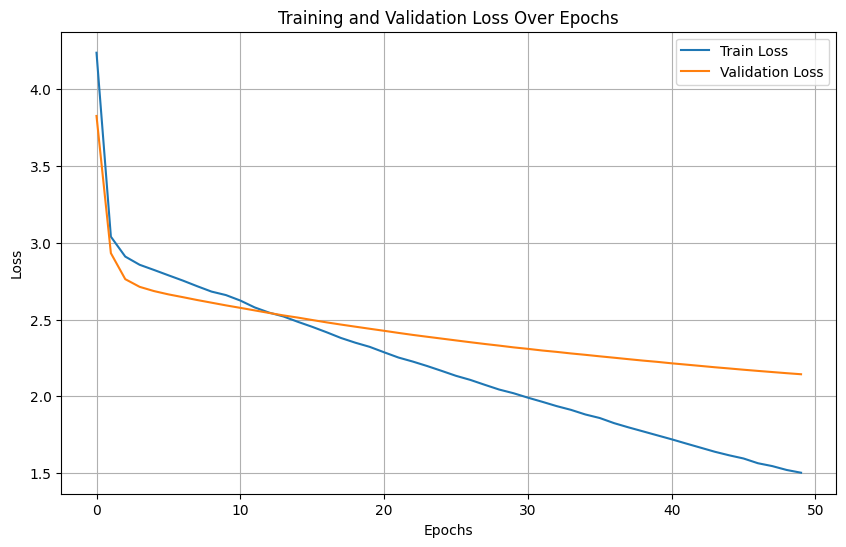

In [18]:
# Plot losses
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses.

    Args:
        train_losses (list of float): List of training losses per epoch.
        val_losses (list of float): List of validation losses per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

# Evaluation

In [11]:
# Restore the model weights from the checkpoint
trained_model = CNN.models.Baseline(input_shape=(MATRIX_DIM, MATRIX_DIM, 1))

checkpoint_path = "runs/matrix_cnn_experiment/best_model_checkpoint"
checkpoint = tf.train.Checkpoint(model=trained_model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

In [19]:
# Evaluate the model on the test set
evaluation_results = CNN.evaluation.evaluate_model(
    model=trained_model,
    test_dataset=test_dataset.batch(8),
    loss_fn=loss_fn
)

True Labels Shape: (6400,)
Predicted Labels Shape: (6400,)
Test Loss: 0.7522
Accuracy: 0.4897
Precision: 0.8025
Recall: 0.4897
F1 Score: 0.5869


# Prediction

In [85]:
# Extract test matrices and labels from dataset
test_matrices = generated_matrices[train_size + val_size:]
test_labels = metadata.block_starts[train_size + val_size:]

# Make Predictions
test_predictions = trained_model.predict(test_dataset.batch(8))

# Convert to Binary
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)

# Calculate Metrics
overall_accuracy = (binary_predictions == test_labels).mean()
print("Overall Accuracy:")
print(overall_accuracy)

13/13 [==============================] - 4s 287ms/step
Overall Accuracy:
0.49078125


# Create Block Jacobi Preconditioner

In [84]:
print(test_matrices.shape)
print(binary_predictions.shape)

(100, 64, 64)
(100, 64)


In [108]:
def block_jacobi_preconditioner_from_predictions(A, binary_predictions):
    """
    Calculates the block Jacobi preconditioner for each 2D matrix in a 3D array using binary predictions for block starts.

    Args:
        A: NumPy array of shape (n, m, m) representing n square matrices of size m x m.
        binary_predictions: NumPy array of shape (n, m) where each row indicates block starts with 1s.

    Returns:
        A NumPy array of the same shape as A representing the block diagonal preconditioner for each 2D matrix.
    """
    n, m, _ = A.shape
    
    # Initialize the preconditioner array
    prec = np.zeros_like(A)
    
    for k in range(n):
        # Find block start indices from binary predictions
        block_starts = np.where(binary_predictions[k] == 1)[0]
        
        # Ensure to include the end of the matrix as a block end
        block_starts = np.append(block_starts, m)
        
        # Extract diagonal blocks
        blocks = []
        for i in range(len(block_starts) - 1):
            start = block_starts[i]
            end = block_starts[i + 1]
            blocks.append(A[k, start:end, start:end])
        
        # Invert diagonal blocks if they are invertible
        inv_blocks = []
        for block in blocks:
            try:
                inv_block = np.linalg.inv(block)
            except np.linalg.LinAlgError:
                # Use pseudoinverse if the block is singular
                inv_block = np.linalg.pinv(block)
            inv_blocks.append(inv_block)
        
        # Create block diagonal matrix for the k-th matrix
        for i, block in enumerate(inv_blocks):
            start = block_starts[i]
            end = block_starts[i + 1]
            prec[k, start:end, start:end] = block
    
    return prec

In [109]:
# Create preconditioner
prec = block_jacobi_preconditioner_from_predictions(test_matrices, binary_predictions)

print("Original Matrix A (first instance):")
print(A[0])
print("\nBlock Jacobi Preconditioner (first instance):")
print(prec[0])

Original Matrix A (first instance):
[[0.52832436 0.39411235 0.22116891 ... 0.2039097  0.16709343 0.40576806]
 [0.42188194 0.91855741 0.34892752 ... 0.20094286 0.41184287 0.84659307]
 [0.53191541 0.45865209 0.48375378 ... 0.81972998 0.92526227 0.38866703]
 ...
 [0.78071993 0.8747129  0.46089798 ... 0.03453556 0.75929956 0.91591997]
 [0.37500341 0.00125971 0.27429119 ... 0.37354107 0.6508323  0.46247384]
 [0.76627715 0.06244696 0.41350925 ... 0.37505693 0.82396123 0.31557809]]

Block Jacobi Preconditioner (first instance):
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           1.17389084 ...   0.           0.
    0.        ]
 [  0.           1.17389084  -0.03670628 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...  -9.07853039   4.32168847
   17.42425899]
 [  0.           0.           0.         ...   4.32168847   0.
   -8.29453843]
 [  0.           0.           0.         ...  17.42425899  -8.294

# GMRES Solver

## Check Condition Number before Preconditioning

In [110]:
print(test_labels.shape)
print(test_labels[0])

(100, 64)
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [116]:
def check_condition_number(matrix):
    try:
        condition_number = np.linalg.cond(matrix)
    except np.linalg.LinAlgError:
        condition_number = float('inf')
    return condition_number

check_condition_number(test_matrices[0])


931.6904215448839

In [114]:

# Convert test_labels to integer indices
block_starts = np.where(test_labels[0] == 1)[0]

# Check condition numbers
for i, matrix in enumerate(test_matrices):
    condition_number = check_condition_number(matrix)
    print(f"Condition number of matrix {i}: {condition_number}")
    block_starts = np.where(binary_predictions[i] == 1)[0]
    block_starts = np.append(block_starts, matrix.shape[0])
    for j in range(len(block_starts) - 1):
        start = block_starts[j]
        end = block_starts[j + 1]
        block = matrix[start:end, start:end]
        block_condition_number = check_condition_number(block)
        print(f"Condition number of block {j} of matrix {i}: {block_condition_number}")
        prec_block = prec[i, start:end, start:end]
        prec_block_condition_number = check_condition_number(prec_block)
        print(f"Condition number of preconditioner block {j} of matrix {i}: {prec_block_condition_number}")

print("Original Matrix A (first instance):")
print(test_matrices[0])
print("\nBlock Jacobi Preconditioner (first instance):")
print(prec[0])

Condition number of matrix 0: 931.6904215448839
Condition number of block 0 of matrix 0: 1.0317616010036759
Condition number of preconditioner block 0 of matrix 0: 1.0317616010036754
Condition number of block 1 of matrix 0: inf
Condition number of preconditioner block 1 of matrix 0: inf
Condition number of block 2 of matrix 0: inf
Condition number of preconditioner block 2 of matrix 0: inf
Condition number of block 3 of matrix 0: 2.7858546131222197
Condition number of preconditioner block 3 of matrix 0: 2.7858546131222206
Condition number of block 4 of matrix 0: 1.0
Condition number of preconditioner block 4 of matrix 0: 1.0
Condition number of block 5 of matrix 0: 36.04812981207312
Condition number of preconditioner block 5 of matrix 0: 36.048129812073185
Condition number of block 6 of matrix 0: 6.454028778605768
Condition number of preconditioner block 6 of matrix 0: 6.454028778605769
Condition number of block 7 of matrix 0: 11.531289304737266
Condition number of preconditioner block

In [94]:
# Run GMRES solver on unconditioned matrices
from scipy.sparse.linalg import gmres

# Define parameters
maxit = 100
tol = 1e-5

solutions_no_preconditioner = []  # List to store solution vectors for all matrices


for i, matrix in enumerate(test_matrices):
    # Convert matrix to sparse format
    A_sparse = scipy.sparse.csr_matrix(matrix)

    # Define right-hand side as a vector of ones
    b = np.ones(matrix.shape[0])

    # Extract the corresponding preconditioner for this matrix
    preconditioner_matrix = scipy.sparse.csr_matrix(prec[i])

    # Run GMRES solver
    x, iteration_number = gmres(A_sparse, b, M=preconditioner_matrix, tol=tol, maxiter=maxit)
    solutions_no_preconditioner.append(x)
    print(f"Matrix {i} solved in {iteration_number}")




ValueError: shapes of A (64, 64) and b (64, 64) are incompatible

In [100]:
solutions_with_preconditioner = []  

for i, matrix in enumerate(test_matrices):
    # Convert matrix to sparse format
    A_sparse = scipy.sparse.csr_matrix(matrix)

    # Define right-hand side as a vector of ones
    b = np.ones(matrix.shape[0])

    # Extract the corresponding preconditioner for this matrix
    preconditioner_matrix = scipy.sparse.csr_matrix(prec[i])

    # Run GMRES solver
    x, exit_code = gmres(A_sparse, b, M=preconditioner_matrix, tol=1e-1, maxiter=5000)
    solutions_with_preconditioner.append(x)
    print(f"Matrix {i} solved with exit code {exit_code}")

print("All matrices solved with preconditioner.")

Matrix 0 solved with exit code 5000


KeyboardInterrupt: 

In [13]:
while True:
    pass

KeyboardInterrupt: 